# Segmentation model Solar Panel

Usage.

Please note the steps are for a windows computer, not linux environment, since the computer with GPU capabilities is using Windows.

1. Usage, please install VsCode and the Jupyter plugin. 
2. Make sure you have install virtual environment, if not, please execute: !pip install virtualenv
3. Once installed, press Ctrl+Shift+P , select Venv , and create a virtual environment. 

In [1]:
# If it's the first time, please uncomment the following line and a warning pop up window is going to appear, click on install for ipykernel package
# If for the first time it will take a lot of minutes.

# Recommendation: Execute on terminal and then set the kernel. 

# Uncomment below: 

# python -m venv .venv 
# .venv\Scripts\activate  
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116!
# pip install -r requirements.txt
 

Data loading from folders

In [2]:
from pathlib import Path
import os

def load_files(folder_route: str):
    dir_path = Path(folder_route)
    folderContent = [os.path.join(dir_path, fn) for fn in next(os.walk(dir_path))[2]]
    return folderContent


TRAIN_IMAGE_DIR = './dataset_segmentation/train/images/'
TRAIN_MASK_DIR = './dataset_segmentation/train/masks/'

TEST_IMAGE_DIR = './dataset_segmentation/test/images/'
TEST_MASK_DIR = './dataset_segmentation/test/masks/'

folder_train_image_content = load_files(TRAIN_IMAGE_DIR)
folder_train_mask_content = load_files(TRAIN_MASK_DIR)
folder_test_image_content = load_files(TEST_IMAGE_DIR)
folder_test_mask_content = load_files(TEST_MASK_DIR)

print('Path: train/images, size: ',len(folder_train_image_content))
print('Path: train/masks, size: ',len(folder_train_mask_content))
print('Path: test/images, size: ',len(folder_test_image_content))
print('Path: test/masks, size: ',len(folder_test_image_content))

Path: train/images, size:  103
Path: train/masks, size:  103
Path: test/images, size:  9
Path: test/masks, size:  9


### Experiment set up

In [3]:
import wandb
import ssl
import logging
import torch


ssl._create_default_https_context = ssl._create_unverified_context


logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

c:\Users\carlo\Documents\Master\MasterTFM\model\segmentation\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using device cuda


## Transformations and data loaders

In [4]:
from scripts.data_loader import load_and_transform

EPOCHS = 150
BATCH_SIZE =1
LEARNING_RATE = 0.0003
THRESHOLD = 0.7
USE_AMP="apex"
TRAIN_PERCENTAGE=0.7
ARCH = "Unet"
ENCODER_NAME="efficientnet-b5"
ENCODER_WEIGHTS="imagenet"
IMAGE_HEIGHT  = 960
IMAGE_WIDTH   = 960
SPECIAL = 'best_v3'
display_name = ARCH+'_'+str(EPOCHS)+'_'+str(TRAIN_PERCENTAGE)+'_'+ENCODER_NAME+'_'+str(IMAGE_HEIGHT)+'_'+str(IMAGE_WIDTH)+'_'+str(THRESHOLD)+'_'+str(LEARNING_RATE)+'_'+str(BATCH_SIZE)+'_'+SPECIAL

experiment=None
train_loader, val_loader, train_ds, train_val_ds, test_loader = load_and_transform(TRAIN_IMAGE_DIR,
 TRAIN_MASK_DIR,TEST_IMAGE_DIR, TEST_MASK_DIR, TRAIN_PERCENTAGE,BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH)


## Segmentation model

In [5]:
experiment = wandb.init(project='Segmentation-TFM', resume='allow', anonymous='must', name=display_name)
experiment.config.update(dict(epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE,
                                  val_size=1-TRAIN_PERCENTAGE, thresh_hold=THRESHOLD,arch=ARCH,encoder_name=ENCODER_NAME,
                                  encoder_weights= ENCODER_WEIGHTS, image_height =IMAGE_HEIGHT, image_width  =IMAGE_WIDTH))

ERROR: Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: carlosan1708. Use `wandb login --relogin` to force relogin


In [6]:
from scripts.segmentation_net import SolarPanelModel

model = SolarPanelModel(ARCH,ENCODER_NAME,ENCODER_WEIGHTS, in_channels=3, out_classes=1, learning_rate=LEARNING_RATE,
threshold=THRESHOLD, experiment=experiment )

In [7]:
import albumentations as A  
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import cv2
import pytorch_lightning as pl
import numpy as np
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=EPOCHS,
    amp_backend=USE_AMP,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min",patience=15)]
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=val_loader, verbose=False)
print(valid_metrics)


INFO: GPU available: True, used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type              | Params
----------------------------------------------
0 | model   | Unet              | 31.2 M
1 | loss_fn | BCEWithLogitsLoss | 0     
----------------------------------------------
31.2 M    Trainable params
0         Non-trainable params
31.2 M    Total params
124.864   Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\carlo\Documents\Master\MasterTFM\model\segmentation\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check:  50%|█████     | 1/2 [00:03<00:03,  3.55s/it]{'valid_per_image_iou': tensor(0.0009, device='cuda:0'), 'valid_dataset_iou': tensor(0.0009, device='cuda:0'), 'valid_loss': tensor(4.6179)}
                                                                      

c:\Users\carlo\Documents\Master\MasterTFM\model\segmentation\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 56: 100%|██████████| 103/103 [01:03<00:00,  1.63it/s, loss=0.0121, v_num=179, valid_per_image_iou=0.987, valid_dataset_iou=0.988, valid_loss=0.0406, train_per_image_iou=0.995, train_dataset_iou=0.995, train_loss=0.0176]


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'valid_per_image_iou': tensor(0.9875, device='cuda:0'), 'valid_dataset_iou': tensor(0.9881, device='cuda:0'), 'valid_loss': tensor(0.0406)}
[{'val_loss': 0.04056665673851967, 'valid_per_image_iou': 0.9874892234802246, 'valid_dataset_iou': 0.9880721569061279, 'valid_loss': 0.04056665673851967}]


## Test metrics

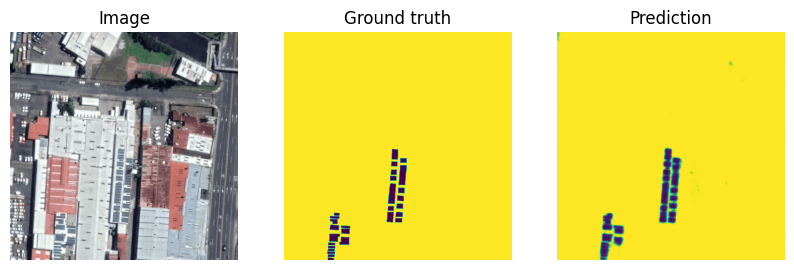

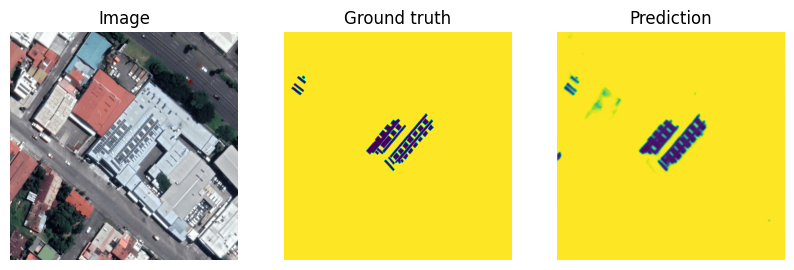

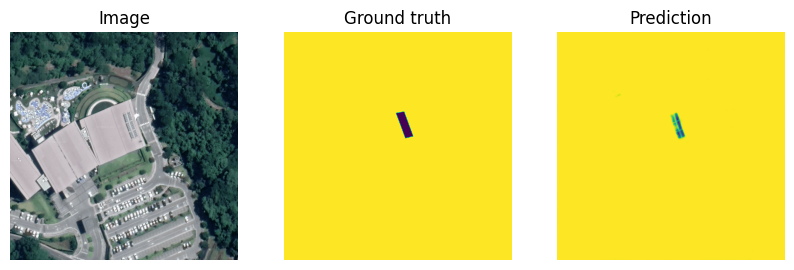

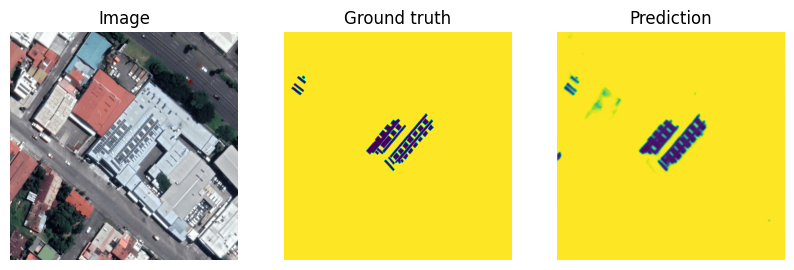

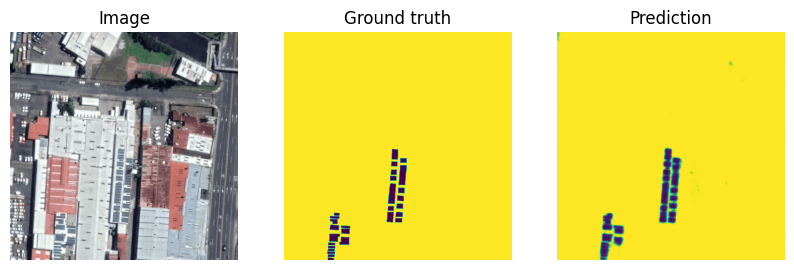

In [8]:
import torch
import matplotlib.pyplot as plt


for x in range(0, 5):
    batch= next(iter(test_loader))
    with torch.no_grad():
        model.eval()
        logits = model(batch["image"])
    pr_masks = logits.sigmoid()

    for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
        plt.title("Prediction")
        plt.axis("off")

        # experiment.log({
        #     'images': wandb.Image(image.numpy().transpose(1, 2, 0)),
        #     'masks': {
        #     'true': wandb.Image(gt_mask.numpy().squeeze()),
        #     'pred': wandb.Image(pr_mask.numpy().squeeze()),
        #     }
        # })
        plt.show()



In [9]:
# Workaround to add later the metrics
test_metrics = trainer.test(model, dataloaders=test_loader, verbose=False)
wandb.finish()

api = wandb.Api()
run = api.run("/carlosan1708/Segmentation-TFM/runs/"+experiment.id)
run.summary["test_per_image_iou"] = test_metrics[0]['test_per_image_iou']
run.summary["test_dataset_iou"] = test_metrics[0]['test_dataset_iou']
run.summary["test_loss"] = test_metrics[0]['test_loss']
run.update()

print(test_metrics)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\carlo\Documents\Master\MasterTFM\model\segmentation\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:453: UserWarning: Your `test_dataloader` has `shuffle=True`,it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
c:\Users\carlo\Documents\Master\MasterTFM\model\segmentation\.venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:111: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 100%|██████████| 9/9 [00:01<00:00,  7.16it/s]


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
valid_dataset_iou,▁▇██████████████████████████████████████
valid_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_per_image_iou,▁▇██████████████████████████████████████
epoch,56
global_step,4104
valid_dataset_iou,0.98807
valid_loss,0.04057
valid_per_image_iou,0.98749


[{'test_per_image_iou': 0.9949989318847656, 'test_dataset_iou': 0.9950289726257324, 'test_loss': 0.01684611476957798}]


## Save

In [10]:
torch.save(model.state_dict(), 'models/'+display_name+'.pt')